# Infer ***ER*** - part 8️⃣

--------------

OBJECTIVE:  ✅ Infer sub-cellular component ***ER*** (***ER***) in order to understand interactome 



Dependencies:
The ***ER***  inference rely on the **cytoplasm** mask. 

## preamble

1. imports
2. setup
3. infer nuclei mask
4. infer cellmask mask
5. infer cytoplasm mask
6. infer ER
    * pre-processing
    * core processing
    * post processing


## IMPORTS

In [43]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
from typing import Optional

import aicssegmentation
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         edge_preserving_smoothing_3d,
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter, hole_filling
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.vessel import filament_2d_wrapper, filament_3d_wrapper
                                                 
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))
from infer_subc.core.file_io import (read_czi_image, 
                                                                    list_image_files)
from infer_subc.core.img import *
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )        

from infer_subc.organelles import fixed_infer_cellmask_fromaggr, fixed_infer_nuclei, infer_cytoplasm, find_optimal_Z


%load_ext autoreload
%autoreload 2


# additional imports for nuc/cellmask/cytoplasm
from collections import defaultdict
from scipy import ndimage as ndi
from aicssegmentation.core.MO_threshold import MO
from skimage import filters
from skimage.segmentation import watershed
from skimage.morphology import (binary_erosion,
                                remove_small_holes)
from skimage.measure import label

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SETUP
CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/infer-subc"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\Anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## INFER NUCLEI MASK

Using function defined in 01_infer_nuclei_3D.ipynb


In [6]:
def _infer_nuclei_3D( in_img: np.ndarray,
                       median_sz: int, 
                       gauss_sig: float,
                       thresh_factor: float,
                       thresh_min: float,
                       thresh_max: float,
                       max_hole_w: int,
                       small_obj_w: int,
                       sz_filter_method: str
                     ) -> np.ndarray:
    """
    Procedure to infer 3D nuclei segmentation from multichannel z-stack input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: Optional[np.ndarray] = None
        mask
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimum object size cutoff for nuclei post-processing
    sz_filter_method: str
        method for size filtering; either "3D" or "slice_by_slice"

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    ###################
    # INPUT
    ################### 
    nuc_ch = NUC_CH
    nuclei = select_channel_from_raw(in_img, nuc_ch)


    ###################
    # PRE_PROCESSING
    ###################                
    nuclei = min_max_intensity_normalization(nuclei)
    nuclei = median_filter_slice_by_slice(nuclei,
                                          size=median_sz)
    nuclei = image_smoothing_gaussian_slice_by_slice(nuclei,
                                                     sigma=gauss_sig )


    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                           thresh_factor=thresh_factor, 
                                           thresh_min=thresh_min, 
                                           thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = hole_filling(nuclei_object, 
                                 hole_min=0, 
                                 hole_max=max_hole_w**2, 
                                 fill_2d=True)

    nuclei_object = size_filter(nuclei_object, 
                                min_size = small_obj_w**3, 
                                method = sz_filter_method,
                                connectivity=1)


    return nuclei_object


def _fixed_infer_nuclei_3D(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    soma_mask: np.ndarray
        mask
 
    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    nuc_ch = NUC_CH
    median_sz = 4   
    gauss_sig = 1.34
    threshold_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.0
    max_hole_w = 5
    small_obj_w = 15
    sz_filter_method = "3D"

    return _infer_nuclei_3D( in_img,
                             median_sz,
                             gauss_sig,
                             threshold_factor,
                             thresh_min,
                             thresh_max,
                             max_hole_w,
                             small_obj_w,
                             sz_filter_method )


_NU_object =  _fixed_infer_nuclei_3D(img_data) 
NU_labels = label(_NU_object)

## GET CELLMASK

Using function defined in 02_infer_cellmask_fromaggr_3D.ipynb

In [7]:
def _raw_soma_MCZ(img_in):
    """ define cellmask image
    """
    SOMA_W = (6.,1.,2.)
    SOMA_CH = (LYSO_CH,ER_CH,GOLGI_CH)
    img_out = np.zeros_like(img_in[0]).astype(np.double)
    for w,ch in zip(SOMA_W,SOMA_CH):
        img_out += w*img_in[ch]
    return img_out


def _non_linear_soma_transform_MCZ(in_img):
    """ non-linear distortion to fill out cellmask
    log + edge of smoothed composite
    """
    # non-Linear processing
    log_img, d = log_transform(in_img.copy()) 
    return intensity_normalization(log_img,scaling_param=[0])


def _masked_object_thresh(
    structure_img_smooth: np.ndarray, th_method: str, cutoff_size: int, th_adjust: float
) -> np.ndarray:
    """
    wrapper for applying Masked Object Thresholding with just two parameters via `MO` from `aicssegmentation`
    Parameters
    ------------
    structure_img_smooth: np.ndarray
        a 3d image
    th_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    cutoff_size: 
        Masked Object threshold `size_min`
    th_adjust: 
        Masked Object threshold `local_adjust`

    Returns
    -------------
        np.ndimage 

    """

    struct_obj = MO(
        structure_img_smooth,
        global_thresh_method=th_method,
        object_minArea=cutoff_size,
        extra_criteria=True,
        local_adjust=th_adjust,
        return_object=False,
        dilate=True,
    )
    return struct_obj


def _masked_inverted_watershed(img_in, markers, mask):
    """wrapper for watershed on inverted image and masked

    """
    labels_out = watershed(
                1. - img_in,
                markers=markers,
                connectivity=3,
                mask=mask,
                )
    return labels_out


def _choose_max_label(raw_signal: np.ndarray, labels_in: np.ndarray):
    """ keep only the label with the maximum raw signal

    """

    all_labels = np.unique(labels_in)[1:]

    total_signal = [raw_signal[labels_in == label].sum() for label in all_labels]
    # combine NU and "labels" to make a SOMA
    keep_label = all_labels[np.argmax(total_signal)]

    labels_max = np.zeros_like(labels_in)
    labels_max[labels_in==keep_label] = 1
    return labels_max

In [8]:
def _infer_cellmask_fromaggr_3D(in_img: np.ndarray,
    nuclei_labels: np.ndarray,
    median_sz_soma: int,
    gauss_sig_soma: float,
    gauss_truc_rang: float,
    mo_method: str,
    mo_adjust: float,
    mo_cutoff_size: int,
    max_hole_w_soma: int,
    small_obj_w_soma: int
) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_labels:
        a 3d mask of nuclei
    median_sz_soma: 
        width of median filter for _soma_ signal
    gauss_sig_soma: 
        sigma for gaussian smoothing of _soma_ signal
    gauss_truc_rang:
        cutoff value for gaussian
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w_soma: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w_soma: 
        minimu object size cutoff for cellmask signal post-processing

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of cellmask

    """

    ###################
    # EXTRACT
    ###################
    struct_img = _raw_soma_MCZ(in_img)


    ###################
    # PRE_PROCESSING
    ###################                         
    ################# part 1- cellmask
    struct_img = min_max_intensity_normalization(struct_img)

    # make a copy for post-post processing
    scaled_signal = struct_img.copy()

    # Linear-ish processing
    struct_img = median_filter_slice_by_slice(struct_img, 
                                              size=median_sz_soma)

    struct_img = ndi.gaussian_filter(struct_img,
                                     sigma=gauss_sig_soma,
                                     mode="nearest",
                                     truncate=gauss_truc_rang)

    struct_img_non_lin = _non_linear_soma_transform_MCZ(struct_img)
   

    ###################
    # CORE_PROCESSING
    ###################    
    struct_obj = _masked_object_thresh(struct_img_non_lin, 
                                       th_method=mo_method, 
                                       cutoff_size=mo_cutoff_size, 
                                       th_adjust=mo_adjust)               


    ###################
    # POST_PROCESSING
    ###################
    struct_obj = hole_filling(struct_obj, 
                              hole_min =0 , 
                              hole_max=max_hole_w_soma**2, 
                              fill_2d = True) 

    struct_obj = size_filter_2D(struct_obj, 
                                min_size= small_obj_w_soma**3, 
                                connectivity=1)

    labels_out = _masked_inverted_watershed(struct_obj, nuclei_labels, struct_obj)


    ###################
    # POST- POST_PROCESSING
    ###################
    # keep the "SOMA" label which contains the highest total signal
    soma_out = _choose_max_label(struct_img, labels_out)

    return soma_out


def _fixed_infer_cellmask_fromaggr_3D(in_img: np.ndarray, nuclei_labels: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_object:
        a 3d mask of nuclei

    Returns
    -------------
    soma_mask:
        a logical/labels object defining boundaries of cellmask
    """
    
    ###################
    # PARAMETERS
    ###################   
    median_sz_soma = 15
    gauss_sig_soma = 1.34
    gauss_truc_rang = 3.0
    mo_method = "ave"
    mo_adjust = 0.15
    mo_cutoff_size = 50
    max_hole_w_soma = 100
    small_obj_w_soma = 45

    soma_out = _infer_cellmask_fromaggr_3D(in_img,
                              nuclei_labels,
                              median_sz_soma,
                              gauss_sig_soma,
                              gauss_truc_rang,
                              mo_method,
                              mo_adjust,
                              mo_cutoff_size,
                              max_hole_w_soma,
                              small_obj_w_soma) 

    return soma_out


SO_label =  _fixed_infer_cellmask_fromaggr_3D(img_data, NU_labels) 

intensity normalization: min-max normalization with NO absoluteintensity upper bound


## GET CYTOSOL MASK


In [9]:
#selecting single nuclei that matches the single cytoplasm selected above
NU_object = np.logical_and(SO_label,NU_labels)

In [10]:
def _infer_cytoplasm(soma_mask, nuclei_object, erode_nuclei = True):
    """
    Procedure to infer cytoplasm from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: 
        a 3d image containing the nuclei signal

    soma_mask: 
        a 3d image containing the cellmask signal

    erode_nuclei: 
        should we erode?

    Returns
    -------------
    cytoplasm_mask 
        boolean np.ndarray
      
    """

    if erode_nuclei:
        cytoplasm_mask = np.logical_and(soma_mask, ~binary_erosion(nuclei_object))
        # cytoplasm_mask = np.logical_xor(soma_mask, binary_erosion(nuclei_object))
    else:
        cytoplasm_mask = np.logical_and(soma_mask, ~nuclei_object)
        # cytoplasm_mask = np.logical_xor(soma_mask, nuclei_object)


    return cytoplasm_mask


cytoplasm_mask = _infer_cytoplasm(SO_label, NU_object) 

---------------------

## infer ***ER***

## summary of steps 

INPUT
- ch 6
- cytoplasm mask

PRE-PROCESSING
- edge preserving scaling

CORE-PROCESSING
- vesselness slice-by-slice

POST-PROCESSING
  - S  - remove objects less than 2x2 pixels (area = 4)

OUTPUT
- object **ER** 


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

>sec61beta  is  good start for ER  as per from [Allen Cell](https://www.allencell.org/cell-observations/category/endoplasmic-reticulum).    

using [seg_sec61b.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aics-segmentation/aicssegmentation/structure_wrapper/seg_sec61b.py)
[seg_sec61b_dual.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_sec61b_dual.py)

[playground_Sec61b.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_Sec61b.ipynb)



## INPUT prototype

In [11]:
###################
# INPUT
###################
raw_er = select_channel_from_raw(img_data, ER_CH)


In [12]:
viewer = napari.Viewer()

23-Feb-23 10:53:43 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x687+0+36 (frame: 1108x734-9-2) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1020x921-2+29 (frame: 1038x968-11-9) margins: 9, 38, 9, 9 minimum size: 612x594 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=630,641 maxtrack=0,0)


In [13]:
viewer.add_image(
    raw_er,
    scale=scale
)

<Image layer 'raw_er' at 0x1fea8b0f760>

## PRE-PROCESSING prototype

In [41]:
###################
# PRE_PROCESSING
###################
er_norm = min_max_intensity_normalization(raw_er)

median_sz = 3
gaus_sigma = 0.7

er_med = median_filter_slice_by_slice(er_norm, size=median_sz)

er_gaus = image_smoothing_gaussian_3d(er_med, sigma=gaus_sigma)

# er_smooth = edge_preserving_smoothing_3d(er_norm)

In [42]:
viewer.add_image(
    er_med,
    scale=scale
)
viewer.add_image(
    er_gaus,
    scale=scale
)

<Image layer 'er_gaus' at 0x1feb94a6cd0>

## CORE PROCESSING prototype

In [71]:
###################
# CORE_PROCESSING
###################

################################
## PARAMETERS for this step ##
# [radius of filament diameter, intensity(higher value = high intensity)]
f3_param = [[4, 0.25], [1, 0.01], [3, 0.001], [5, 0.1]]
################################
bw = filament_3d_wrapper(er_gaus, f3_param)

In [73]:
viewer.add_image(
    bw,
    scale=scale
)

<Image layer 'bw' at 0x1fe902fd340>

## POST-PROCESSING prototype

In [76]:

###################
# POST_PROCESSING
###################
################################
## PARAMETERS for this step ##
small_object_width = 4
################################
er_masked = apply_mask(bw, cytoplasm_mask)

er_mask = size_filter(er_masked, 
                        min_size= small_object_width**3, 
                        connectivity=1)
# ################################
# ## PARAMETERS for this step ## from seg_sec61b.py
# min_area = 15
# ################################
# bw = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)
# # prune slice by slice
# for zz in range(bw.shape[0]):
#     bw[zz, :, :] = remove_small_objects(bw[zz, :, :], min_size=3, connectivity=1, in_place=False)

# ER_object = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)

er_objects = label(er_mask)

In [77]:
viewer.add_image(
    er_masked,
    scale=scale
)
viewer.add_image(
    er_mask,
    scale=scale
)
viewer.add_labels(
    er_objects,
    scale=scale
)

<Labels layer 'er_objects' at 0x1fec12755b0>

## DEFINE `infer_ER` function

Based on the _prototyping_ above define the function to infer the er.  


In [88]:
##########################
#  infer_ER
##########################
def _infer_ER_3D(in_img: np.ndarray,
                                cytoplasm_mask: np.ndarray,
                                median_sz: int,
                                gaus_sigma: float,
                                f3_param: list,
                                small_obj_w: int) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cytoplasm_mask:
        mask of cytoplasm
    f3_param:
        a list of [filament_scale, filament_cutoff] values for each size/intensity of the filament objects to be segmented
        Ex) [[1,0.5], [4,0.2],...]
        filament_scale = scale (log_sigma) for filament filter
        filament_cutoff = threshold for filament filtered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    er_ch = ER_CH
    ###################
    # EXTRACT
    ###################    
    er = select_channel_from_raw(in_img, er_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    er = min_max_intensity_normalization(er)

    # edge-preserving smoothing (Option 2, used for Sec61B)
    # er = edge_preserving_smoothing_3d(er)

    er = median_filter_slice_by_slice(er, size=median_sz)

    er = image_smoothing_gaussian_3d(er, sigma=gaus_sigma)

   ###################
    # CORE_PROCESSING
    ###################
    # f2_param = [[filament_scale, filament_cut]]
    # # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
    # struct_obj = filament_2d_wrapper(er, f2_param)

    struct_obj = filament_3d_wrapper(er, f3_param)

    ###################
    # POST_PROCESSING
    ################### 
    struct_obj = apply_mask(struct_obj, cytoplasm_mask)

    struct_obj = size_filter(struct_obj, 
                            min_size= small_obj_w**3, 
                            connectivity=1)


    return struct_obj

# TEST  `_fixed_infer_ER` function

In [91]:
##########################
#  fixed_infer_ER
##########################
def _fixed_infer_ER_3D(in_img: np.ndarray, 
                                                cytoplasm_mask: Optional[np.ndarray] = None
                                            ) -> np.ndarray:
    """
    Procedure to infer endoplasmic rediculum from linearly unmixed input with *fixed parameters*

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cytoplasm_mask: 

        mask - default=None

    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    median_sz = 3
    gaus_sigma = 0.7
    f3_param = [[4, 0.25], [1, 0.01], [3, 0.001], [5, 0.1]]
    small_obj_w = 4
    return _infer_ER_3D(in_img,
                                            cytoplasm_mask,
                                            median_sz,
                                            gaus_sigma,
                                            f3_param,
                                            small_obj_w)                                           
    
    

# TEST  `_infer_ER` function

In [93]:

_er_mask =  _fixed_infer_ER_3D(img_data, cytoplasm_mask) 

_er_objects = label(_er_mask)


In [94]:
viewer.add_image(
    _er_mask,
    scale=scale
)
viewer.add_labels(
    _er_objects,
    scale=scale
)

<Labels layer '_er_objects' at 0x1fec34b58e0>

STOPPED 2D-TO-3D TRANSITION HERE

In [18]:
from infer_subc.organelles import fixed_infer_ER

er_object =  fixed_infer_ER(img_2D, cytoplasm_mask) 


## Visualize  2


In [19]:

viewer.add_image(
    er_object,
    scale=scale
)
viewer.add_labels(
    label(er_object),
    scale=scale
)


viewer.add_image(
    _er_object,
    scale=scale
)

<Image layer '_er_object' at 0x1822fdfd0>

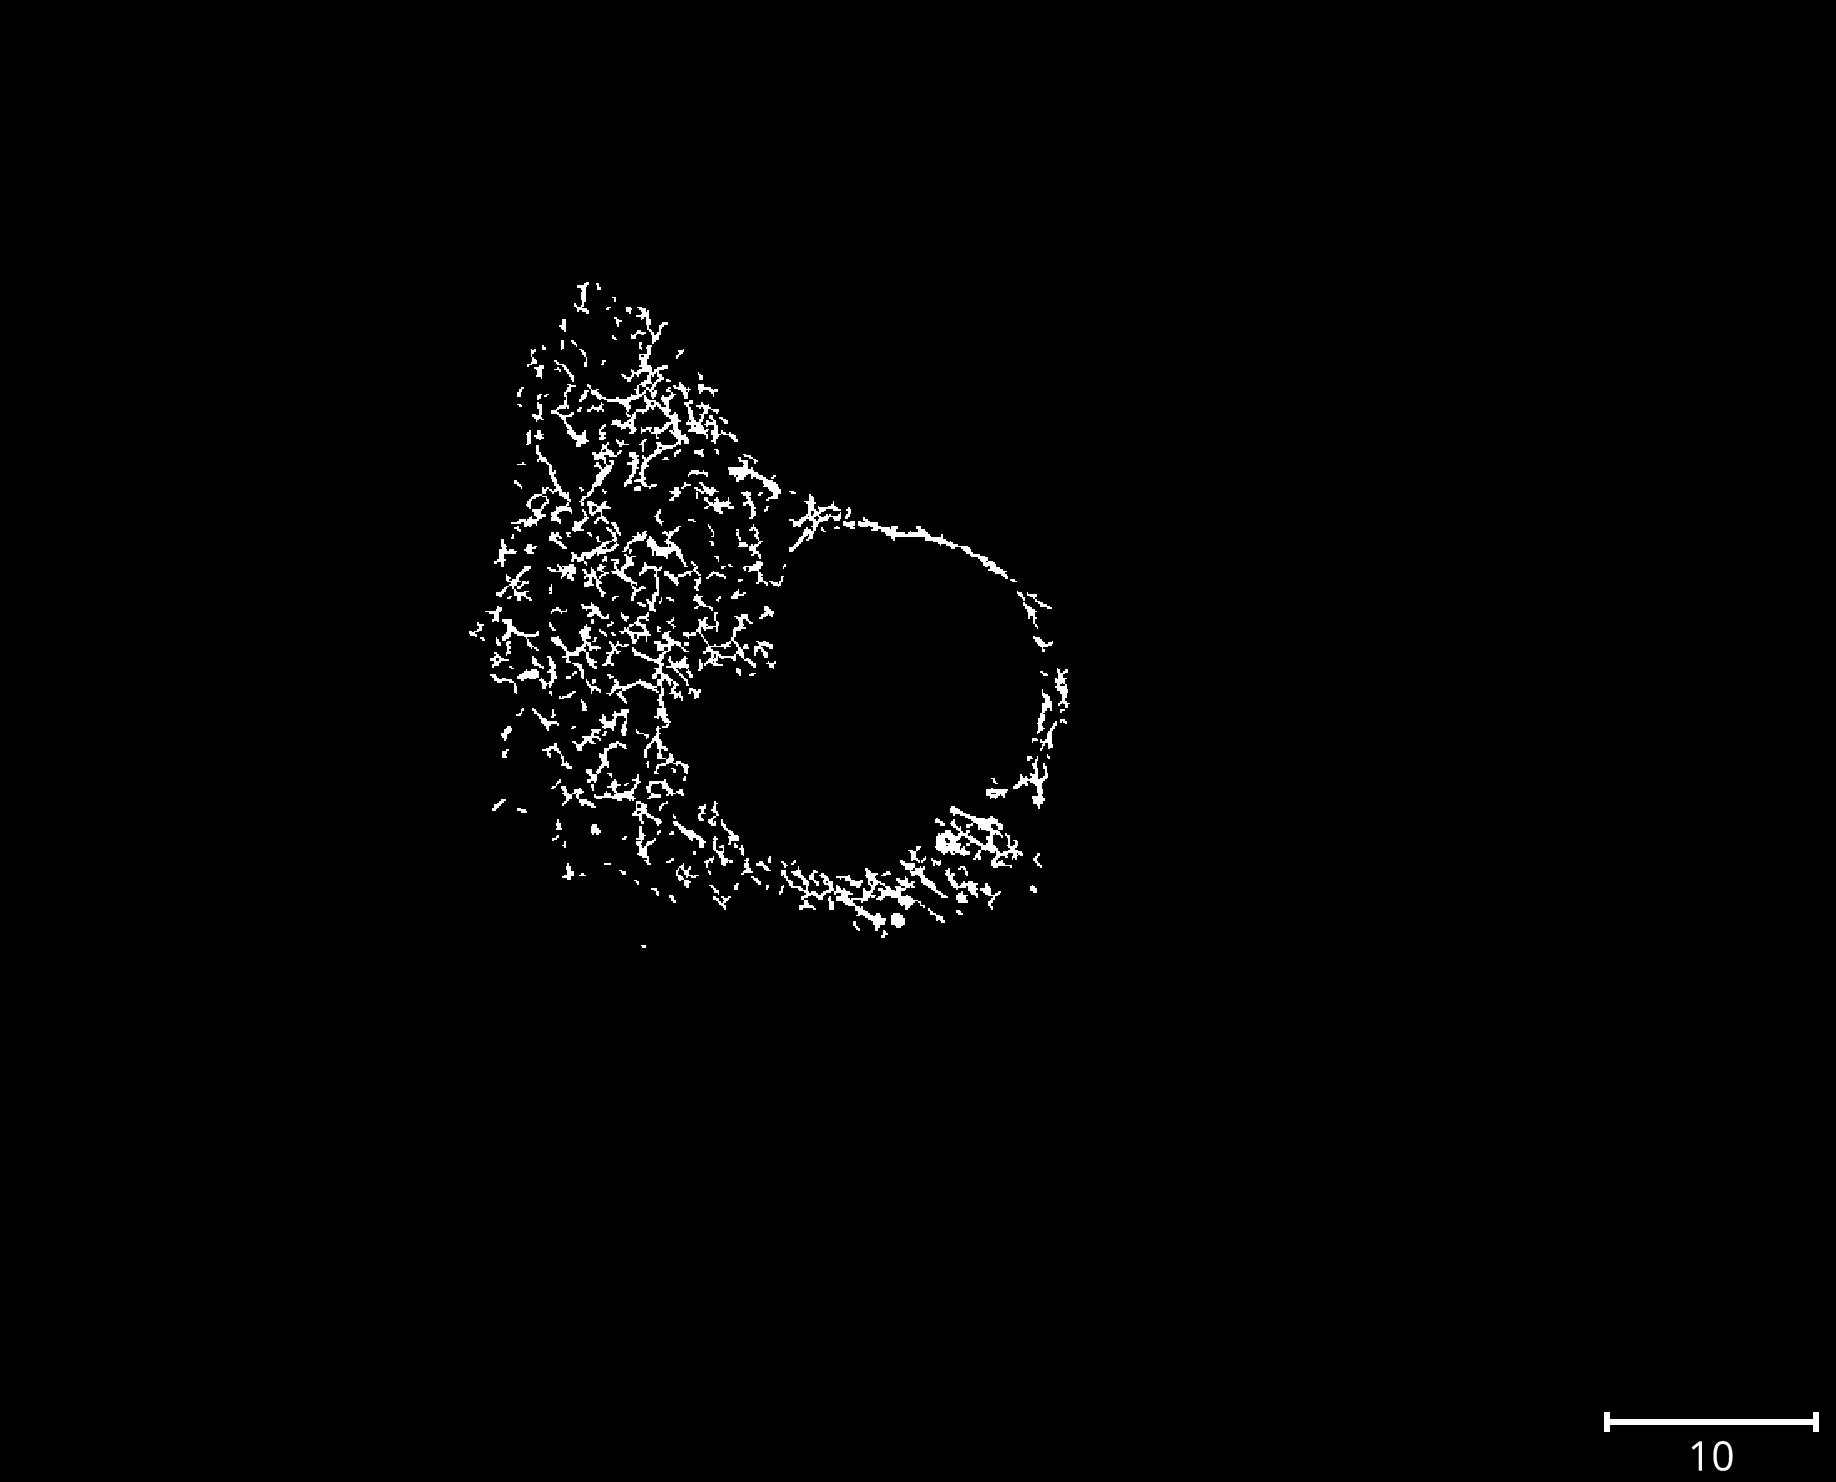

In [20]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-----------------
Write the `infer_ER` spec to the widget json 

In [22]:
from infer_subc.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_er =  {
        "name": "infer ER  (fixed parameters)",
        "python::module": "infer_subc.organelles",
        "python::function": "fixed_infer_ER",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_er",_fixed_infer_er, overwrite=True)

function fixed_infer_er is already in all_functions.json
overwriting  fixed_infer_er


1

In [23]:

_infer_er =  {
        "name": "Infer Endoplasmic Reticulum",
        "python::module": "infer_subc.organelles",
        "python::function": "infer_ER",
        "parameters": {
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_er", _infer_er, overwrite=True )



function infer_er is already in all_functions.json
overwriting  infer_er


1

##  helper function definitions

Wrappers for vessleness filters

In [24]:

_filament_filter =  {
        "name": "filament filter thresholding",
        "python::module": "infer_subc.core.img",
        "python::function": "filament_filter",
        "parameters": {
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
        }
}

add_function_spec_to_widget_json("filament_filter", _filament_filter, overwrite=True )



function filament_filter is already in all_functions.json
overwriting  filament_filter


1

-------------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [25]:
from infer_subc.constants import ER_CH
def make_infer_er_step_by_step_from_raw_dict():
    """
    Procedure to infer mitochondria from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_cellmask_fromaggr")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytoplasm")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = ER_CH) )
    parent.append(1)
    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("edge_preserving_smoothing")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(6)

    step_name.append("8")
    function_name.append("filament_filter") 
    category.append("core")
    parameter_values.append( dict( filament_scale=1., filament_cut=.15) )
    parent.append(7)

    step_name.append("9")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([8,4])

    step_name.append("10")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 2**2  ))
    parent.append(9)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict



In [26]:
from infer_subc.organelles_config.helper import write_workflow_json

infer_er_stepbystep_from_raw_dict = make_infer_er_step_by_step_from_raw_dict()

write_workflow_json("conf_1.8.er_stepbystep_from_raw", infer_er_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc/infer_subc/organelles_config/conf_1.8.er_stepbystep_from_raw.json')

In [27]:
viewer.close()

-------------
## SUMMARY

The above details how the ER object is inferred.  

### NEXT: INFER LIPID BODY

proceed to [09_infer_LD_body.ipynb](./09_infer_LD_body.ipynb)
